# Laboratorium 02 - Metoda najmniejszych kwadatów
## Błażej Naziemiec i Szymon Żuk
### 18 marca 2025

## Wstęp
Celem zadania jest zastosowanie metody najmniejszych kwadratów do predykcji, czy nowotwór jest złośliwy (ang. $\textit{malignant}$)
czy łagodny (ang. $\textit{benign}$).
Nowotwory złośliwe i łagodne mają różne charakterystyki wzrostu. Istotne cechy to m. in. promień i tekstura.
Charakterystyki te wyznaczane są poprzez diagnostykę obrazową i biopsje.

Na początku zaczytaliśmy dane z przygotowanych plików .dat i wrzuciliśmy je na histogram oraz wykres punktowy. W wykresie punktowym zgodnie z poleceniem posortowaliśmy wartośc kolumny od najmniejszej do największej. Wybraliśmy $\textit{symmetry (mean)}$ do przedstawienia na historgramie oraz wykresie.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [19]:
with open("dataset/breast-cancer.labels", "r") as f:
    labels = [line.strip() for line in f.readlines()]
train_data = pd.io.parsers.read_csv("dataset/breast-cancer-train.dat", names=labels)
validate_data = pd.io.parsers.read_csv("dataset/breast-cancer-validate.dat", names=labels)
train_data_malignant = train_data[train_data["Malignant/Benign"] == "M"]
train_data_benign = train_data[train_data["Malignant/Benign"] == "B"]

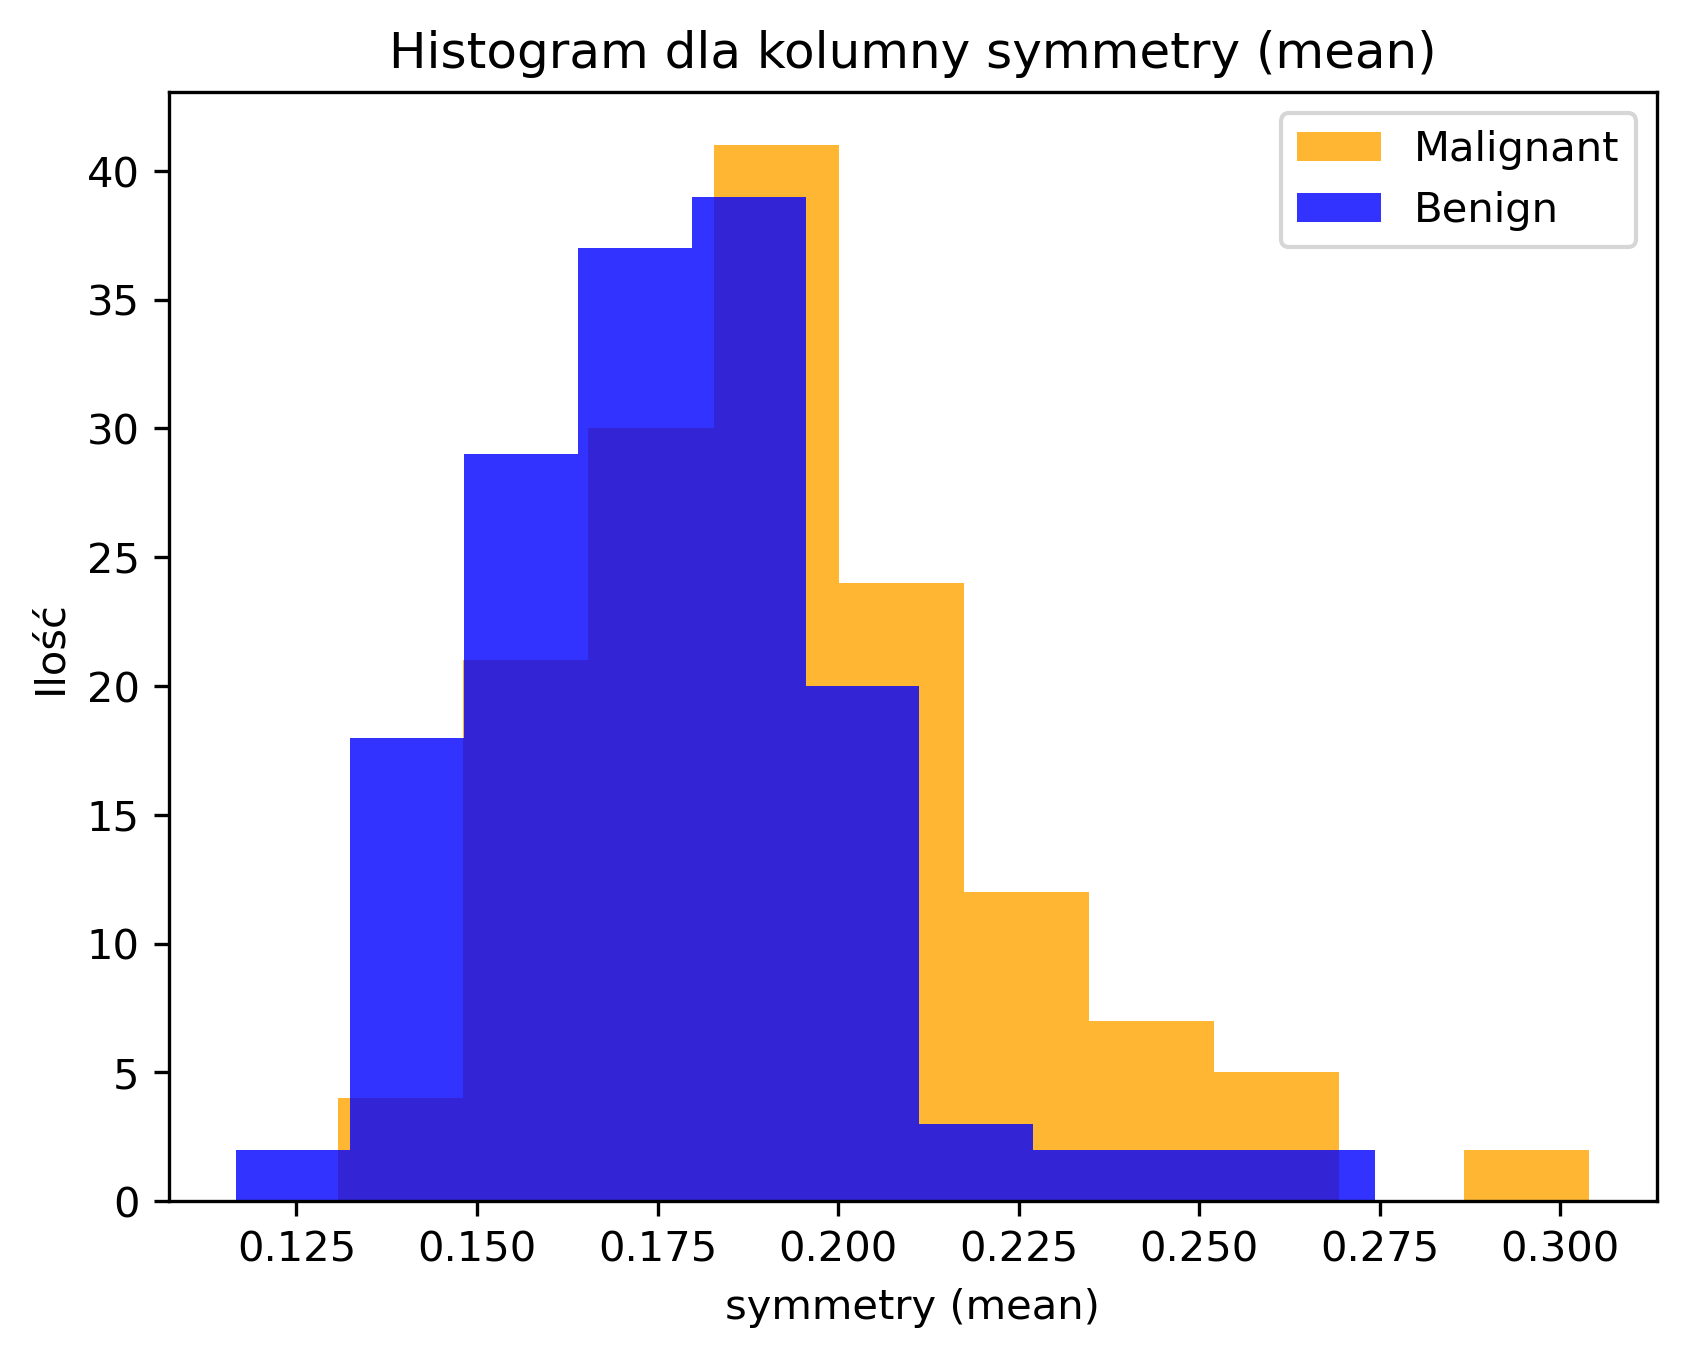

In [33]:
test_column = 10
test_column_name = labels[test_column]
plt.figure(dpi=300)
plt.hist(train_data_malignant[labels[test_column]], alpha=0.8, label='Malignant', color='orange')
plt.hist(train_data_benign[labels[test_column]], alpha=0.8, label='Benign', color='blue')
plt.xlabel(test_column_name)
plt.ylabel("Ilość")
plt.title(f"Histogram dla kolumny {test_column_name}")
plt.legend()
plt.show()

*Rysunek 1. Histogram dla cechy $\textit{symmetry (mean)}$*

Rozkład dla nowotworów złośliwych jest przesunięty w prawo, co wskazuje, że złośliwe guzy nowotworowe zazwyczaj są bardziej symetryczne niż łagodne. Największa koncentracja dla nowotowrów złośliwych jest w okolicach 0.200, a dla łagodnych w okolicach 0.180.  

In [21]:
sorted_train_data_malignant = train_data_malignant[labels[test_column]].sort_values().reset_index(drop=True)
sorted_train_data_benign = train_data_benign[labels[test_column]].sort_values().reset_index(drop=True)

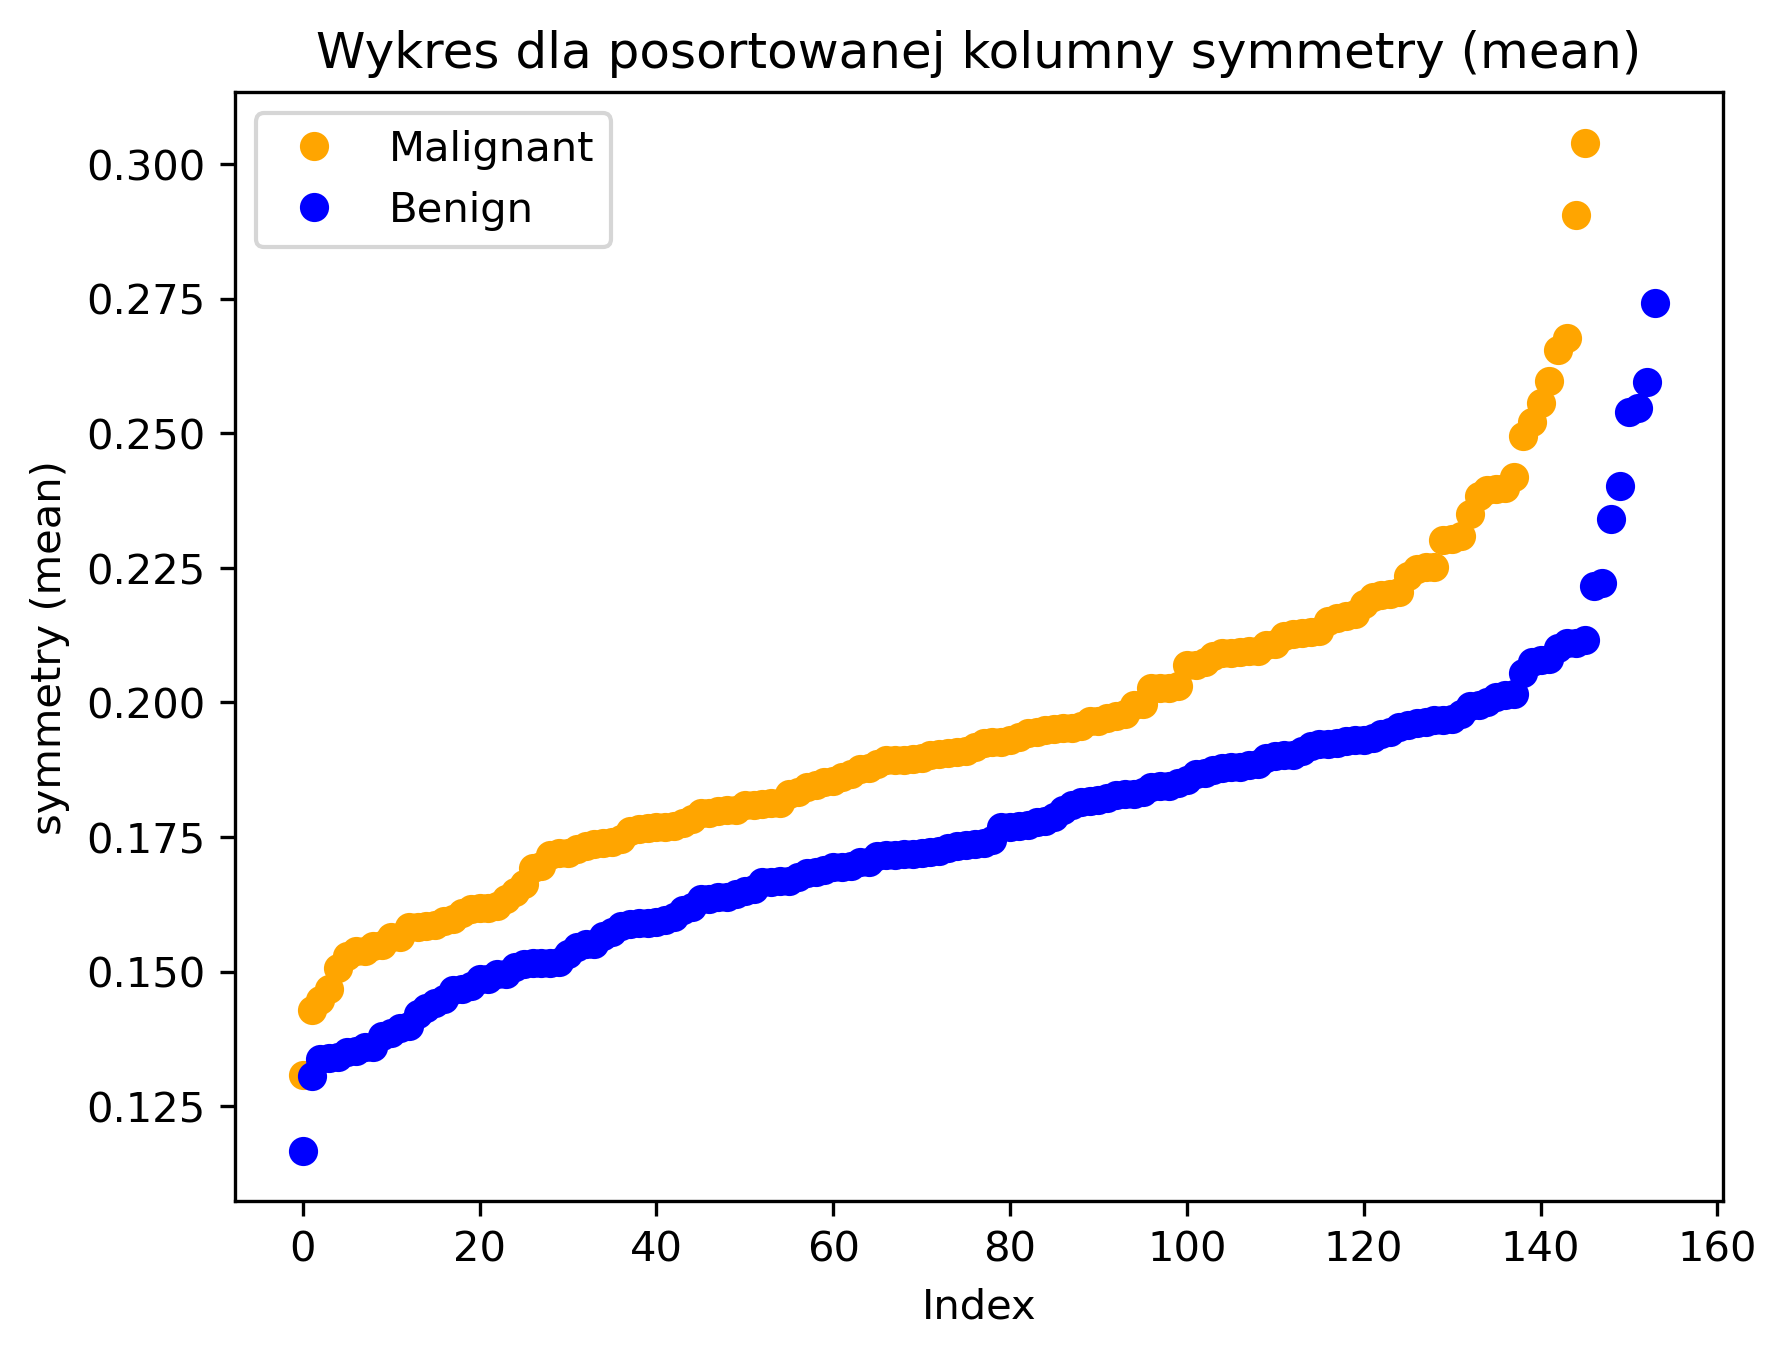

In [37]:
test_column = 10
test_column_name = labels[test_column]
plt.figure(dpi=300)
plt.plot(range(len(sorted_train_data_malignant)), sorted_train_data_malignant.values, 'o', label='Malignant', color='orange')
plt.plot(range(len(sorted_train_data_benign)), sorted_train_data_benign.values, 'o', label='Benign', color='blue')
plt.ylabel(test_column_name)
plt.xlabel("Index")
plt.title(f"Wykres dla posortowanej kolumny {test_column_name}")
plt.legend()
plt.show()

*Rysunek 2 Wykres punktowy dla cechy $\textit{symmetry (mean)}$*

Dane dla nowotworów złośliwych (pomarańczowe punkty) są generalnie wyżej na wykresie niż dane dla nowotworów łagodnych, co potwierdza wcześniejszą obserwację, że złośliwe guzy nowotorowe są bardziej symetryczne niż łagodne.

## Macierze dla liniowej i kwadratowej metody najmniejszych kwadratów

### Przygotowanie danych

Stworzyliśmy reprezentacje danych zawartych w obu zbiorach dla liniowej i kwadratowej metody najmniejszych kwadratów. W następnym kroku stworzyliśmy wektor $b$ dla zbiorów nowotworów łagodnych oraz złośliwych. Następnie znaleźliśmy wagi dla liniowej oraz kwadratowej reprezentacji najmniejszych kwadratów
przy pomocy wcześniej stworzonych macierzy i wektora $b$ z zbioru danych treningowych. Znaleźliśmy też zbiór wag przy użyciu funkcji `np.linalg.lstsq` z $$ \lambda  = 0.01 $$

In [23]:
linear_train = train_data.drop(["patient ID", "Malignant/Benign"], axis=1).values
linear_validate = validate_data.drop(["patient ID", "Malignant/Benign"], axis=1).values

def create_quadratic_representation(data):
    df = data.copy()
    for i in range(len(quad_columns)):
        df[f"{i}^2"] = data[quad_columns[i]] ** 2
    for i in range(len(quad_columns)):
        for j in range(i + 1, len(quad_columns)):
            df[f"{i}_{j}"] = data[quad_columns[i]] * data[quad_columns[j]]
    return df.values

quad_columns = ["radius (mean)", "perimeter (mean)", "area (mean)", "symmetry (mean)"]
quadratic_train = create_quadratic_representation(train_data[quad_columns])
quadratic_validate = create_quadratic_representation(validate_data[quad_columns])

In [24]:
b_training = np.where(train_data[['Malignant/Benign']] == "M", 1, -1)
b_validate = np.where(validate_data[['Malignant/Benign']] == "M", 1, -1)

In [25]:
cov_mat_lin = linear_train.T @ linear_train
cov_mat_quad = quadratic_train.T @ quadratic_train

In [26]:
weights_linear = np.linalg.solve(cov_mat_lin, linear_train.T @ b_training)
weights_quadratic = np.linalg.solve(cov_mat_quad, quadratic_train.T @ b_training)

In [27]:
λ = 0.01
scipy.linalg.lstsq(cov_mat_lin + λ * np.eye(cov_mat_lin.shape[0]), linear_train.T @ b_training);

### Wyznaczenie współczynnika uwarunkowania macierzy dla liniowej i kwadratowej metody najmniejszych kwadratów

Za pomocą funkcji `np.linalg.cond` wyznaczyliśmy współczynnik uwarunkowania macierzy dla liniowej i kwadratowej metody najmniejszych kwadratów. Dla poszczególnych metod otrzymaliśmy następujące wyniki:

  - Dla liniowej metody najmniejszych kwadratów: $1.8092 * 10^{12}$
  - Dla kwadratowej metody najmniejszych kwadratów: $9.0568 * 10^{17}$

Wartości zarówno dla liniowej, jak i kwadratowej metody najmniejszych kwadratów są duże, co oznacza, że macierze są źle uwarunkowane. Wartości dla macierzy kwadartowej są bardzo wysokie. 

In [39]:
cond_lin = np.linalg.cond(cov_mat_lin)
cond_quad = np.linalg.cond(cov_mat_quad)

In [29]:
p_lin = linear_validate @ weights_linear
p_quad = quadratic_validate @ weights_quadratic

## Sprawdzenie, jak dobrze otrzymane wagi przewidują typ nowotworu

Dla poszczególnych metod przedstawiamy wyniki klasyfikacji dla danych testowych. W tabeli przedstawiamy wartości TP, TN, FP, FN oraz dokładność klasyfikacji.

  - TP - liczba przypadków prawdziwie dodatnich
  - TN - liczba przypadków prawdziwie ujemnych
  - FP - liczba przypadków fałszywie dodatnich 
  - FN - liczba przypadków fałszywie ujemnych
  - Accuracy - dokładność klasyfikacji ($\frac{TP + TN}{TP + TN + FP + FN}$)

| TP | TN | FP | FN | Accuracy |
|-------|------|-------|------|----------|
| 58     | 194    | 6     | 2    | 96.92%      |

*Tabela 1. Wyniki klasyfikacji dla liniowej metody najmniejszych kwadratów*

| TP | TN | FP | FN | Accuracy |
|-------|------|-------|------|----------|
| 55     | 185    | 15     | 5    | 92.31%      |

*Tabela 2. Wyniki klasyfikacji dla kwadratowej metody najmniejszych kwadratów*

Porównując wyniki przedstawione w tabelach $(1)$ i $(2)$ można zauważyć, że liniowa metoda najmniejszych kwadratów daje lepsze wyniki klasyfikacji niż kwadratowa metoda najmniejszych kwadratów. Dokładność klasyfikacji dla liniowej metody wynosi $96.92\%$, a dla kwadratowej $92.31\%$. Warto jednak zauważyć, że poprawność wyników obu metod jest bardzo wysoka. Świadczy to o poprawności zaimplementowanych rozwiązań.


In [41]:
def calc_acc(p_vec, b_vec):
    tp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b > 0])
    tn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b < 0])
    fp = np.sum([1 for p, b in zip(p_vec, b_vec) if p > 0 and b <= 0])
    fn = np.sum([1 for p, b in zip(p_vec, b_vec) if p <= 0 and b > 0])
    return int(tp), int(tn), int(fp), int(fn), float((tp + tn) / (tp + tn + fp + fn))

tp_lin, tn_lin, fp_lin, fn_lin, acc_lin = calc_acc(p_lin, b_validate)
tp_quad, tn_quad, fp_quad, fn_quad, acc_quad = calc_acc(p_quad, b_validate)